In [3]:
# @ title Imports

from UNet import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [43]:
# @ title Load the data and pool
def load_data(file_name='ERA5_Data/2023_SouthAfrica.nc'):
    ds = xr.open_dataset(file_name)
    ds.load()

    ds['ws'] = (ds.u10**2 + ds.v10**2)**0.5

    lat_slice = slice(1, 33)  
    lon_slice = slice(3, 67)  

    subset_ds = ds.isel(latitude=lat_slice, longitude=lon_slice)

    latitude_factor = subset_ds.sizes['latitude'] // 16
    longitude_factor = subset_ds.sizes['longitude'] // 32

    ds_pooled = subset_ds.coarsen(latitude=latitude_factor, longitude=longitude_factor).mean()

    return ds_pooled

ds = xr.open_dataset('ERA5_Data/2023_SouthAfrica.nc')
ds.load()

ds['ws'] = (ds.u10**2 + ds.v10**2)**0.5

lat_slice = slice(1, 33)  
lon_slice = slice(3, 67)  


subset_ds = ds.isel(latitude=lat_slice, longitude=lon_slice)

latitude_factor = subset_ds.sizes['latitude'] // 16
longitude_factor = subset_ds.sizes['longitude'] // 32

ds_pooled = subset_ds.coarsen(latitude=latitude_factor, longitude=longitude_factor).mean()

# Print the dimensions of the pooled data
print(ds_pooled['ws'].shape)

ds = ds_pooled


(8760, 16, 32)


In [22]:
# @title Sanity Check

from plot_animation import *

data = {
    " ": scale(select(ds_pooled, variable = 'ws', level = 1000, max_steps=5),
              robust=True),
}


plot_data(data, fig_title= 'Wind Speed', plot_size = 7, robust=True)

In [23]:
window_size = 3
variable = 'ws'

X, y = [], []

for i in range(ds.time.size - window_size):
    X.append(ds[variable].isel(time=slice(i, i + window_size)))
    y.append(ds[variable].isel(time=i + window_size))

X_ = np.array(X) 
y_ = np.array(y)

# Train Validation Split
split = round(X_.shape[0] * 0.9)

# Shape fixing
lon_shape = ds.longitude.size
lat_shape = ds.latitude.size

# Custom Shapes for the data
# lon_shape = 64
# lat_shape = 32
# X_ = X_[:,:, 1:33, 3:67]
# y_ = y_[:,1:33,3:67]

# Normalization
max_ws = X_.max()
X_n = X_ / max_ws
y_n = y_ / max_ws

# Splitting
f_train, t_train = X_n[:split].astype('float32'), y_n[:split].astype('float32')
f_test, t_test = X_n[split:].astype('float32'), y_n[split:].astype('float32')
print('Train Shape: ', f_train.shape, t_train.shape, '\n\nTest Shape: ', f_test.shape, t_test.shape)

X_n = X_n.reshape(-1, lat_shape, lon_shape, window_size)
y_n = y_n.reshape(-1, lat_shape, lon_shape,  1)

f_training, t_training = X_n[:split].astype('float32'), y_n[:split].astype('float32')
f_testing, t_testing = X_n[split:].astype('float32'), y_n[split:].astype('float32')



Train Shape:  (7881, 3, 16, 32) (7881, 16, 32) 

Test Shape:  (876, 3, 16, 32) (876, 16, 32)


In [24]:
def build_RRnet(input_shape, steps = 1):
    inputs = Input(input_shape)

    s1, p1 = RR_encoder_block(inputs, 16)
    s2, p2 = RR_encoder_block(p1, 32)
    # s3, p3 = encoder_block(p2, 256)
    # s4, p4 = encoder_block(p3, 512)

    b1 = RR_block(p2, 64) #Bridge

    # d1 = decoder_block(b1, s4, 512)
    # d2 = decoder_block(d1, s3, 256)
    d3 = RR_decoder_block(b1, s2, 32)
    d4 = RR_decoder_block(d3, s1, 16)

    outputs = Conv2D(steps, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [26]:
input_shape = tuple((1, lat_shape, lon_shape, window_size))
plot_shape = t_training[0].shape

model = build_RRnet(input_shape[1:])

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 16, 32, 3)]          0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 16, 32, 16)           448       ['input_2[0][0]']             
                                                                                                  
 conv2d_37 (Conv2D)          (None, 16, 32, 16)           2320      ['conv2d_36[0][0]']           
                                                                                                  
 batch_normalization_30 (Ba  (None, 16, 32, 16)           64        ['conv2d_37[0][0]']           
 tchNormalization)                                                                            

In [27]:
batch_size = 64
epochs = 500
model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('synth_RR.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')

if True:
    history = model.fit(
        f_training,
        t_training,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(f_testing, t_testing),
        callbacks=[early_stopping, model_checkpoint]
    )


Epoch 1/500

124/124 [==============================] - ETA: 0s - loss: 0.0147
Epoch 1: val_loss improved from inf to 0.01325, saving model to synth_RR.h5


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 19s 103ms/step - loss: 0.0147 - val_loss: 0.0133
Epoch 2/500
123/124 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 2: val_loss improved from 0.01325 to 0.01323, saving model to synth_RR.h5
124/124 [==============================] - 15s 118ms/step - loss: 0.0037 - val_loss: 0.0132
Epoch 3/500
123/124 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 3: val_loss improved from 0.01323 to 0.00903, saving model to synth_RR.h5
124/124 [==============================] - 14s 116ms/step - loss: 0.0028 - val_loss: 0.0090
Epoch 4/500
123/124 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 4: val_loss improved from 0.00903 to 0.00369, saving model to synth_RR.h5
124/124 [==============================] - 15s 118ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 5/500
123/124 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 5: val_loss improved from 0.00369 to 0.00291, saving model to synth_RR.h5


KeyboardInterrupt: 

1/1 [==============================] - 0s 24ms/step


C:\Users\23603526\AppData\Local\Temp\ipykernel_7876\2371036986.py:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([im], labels=['Prediction'], loc='lower center', bbox_to_anchor=(0.5, -0.05))


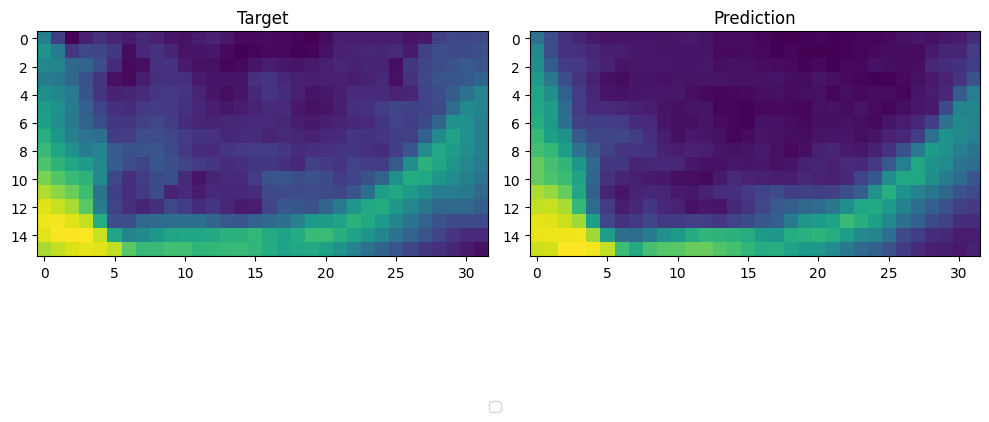

In [38]:
model.load_weights('synth_RR.h5')

seed = 10

pred = model.predict(f_train[seed:seed + 1].reshape(input_shape)).reshape(plot_shape).squeeze()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(t_train[seed].reshape(plot_shape).squeeze(), label='Target')
ax[0].set_title('Target') 
im = ax[1].imshow(pred, label='Prediction')
ax[1].set_title('Prediction')  
fig.legend([im], labels=['Prediction'], loc='lower center', bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()  
plt.show()

In [32]:
# @title Validation Plotting Functions

def plot_state(state, prediction=None, target=None):
    add = 0
    if prediction is not None:
        add += 1
    if target is not None:
        add += 1
        
    fig, ax = plt.subplots(1, state.shape[0] + add, figsize=(20, 5))
    for i in range(state.shape[0]):
        ax[i].imshow(state[i])
        ax[i].set_title(f'Input {i}')
        plt.colorbar(ax[i].imshow(state[i]), ax=ax[i])

    if prediction is not None:
        ax[state.shape[0]].imshow(prediction)
        ax[state.shape[0]].set_title('Prediction')
        plt.colorbar(ax[state.shape[0]].imshow(prediction), ax=ax[state.shape[0]])
                     
    if target is not None:
        ax[state.shape[0]- 1 + add].imshow(target)
        ax[state.shape[0]- 1 + add].set_title('Target')
        plt.colorbar(ax[state.shape[0] - 1 + add].imshow(target), ax=ax[state.shape[0]- 1 + add])

    plt.show()

def rollout(model, current_state, steps, input_shape, plot_shape, t_test, plot = False):
    output = []
    for i in range(steps):
        pred = model.predict(current_state.reshape(input_shape)).reshape(plot_shape)
        if plot:
            plot_state(current_state[0], prediction=pred, target=t_test[i])
        current_state = current_state[:,1:]
        current_state = np.append(current_state, pred.reshape(1, 1, pred.shape[0], pred.shape[1]), axis=1)
        output.append(pred)

    return np.array(output).squeeze()

In [39]:
# @title Image Validation

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

model.load_weights('synth_RR.h5')

seed = 10

steps = 10

targets = t_test[seed:seed + steps]

rollout_pred = rollout(model, f_test[seed:seed + 1], steps, input_shape, plot_shape, t_test, plot=False)

rollout_pred = rollout_pred * max_ws
targets = targets * max_ws

mse = mean_squared_error(targets.flatten(), rollout_pred.flatten())
mae = mean_absolute_error(targets.flatten(), rollout_pred.flatten())
mape = mean_absolute_percentage_error(targets.flatten(), rollout_pred.flatten())
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}, Mean Absolute Error: {mae}, Mean Absolute Percentage Error: {mape}, Root Mean Squared Error: {rmse}')

1/1 [==============================] - 0s 23ms/step
Mean Squared Error: 1.8007590770721436, Mean Absolute Error: 0.9832971692085266, Mean Absolute Percentage Error: 0.5202734470367432, Root Mean Squared Error: 1.3419235944747925


In [41]:
# Create DataSet

latitudes = ds.latitude
longitudes = ds.longitude
time = ds.time[seed:seed+steps]

rollout_pred_da = xr.DataArray(rollout_pred, dims=('time', 'latitude', 'longitude'),
                               coords={'time': time, 'latitude': latitudes, 'longitude': longitudes})
target_da = xr.DataArray(targets, dims=('time', 'latitude', 'longitude'),
                                 coords={'time': time, 'latitude': latitudes, 'longitude': longitudes})
latitudes_da = xr.DataArray(latitudes, dims=('latitude'), coords={'latitude': latitudes})
longitudes_da = xr.DataArray(longitudes, dims=('longitude'), coords={'longitude': longitudes})
time_da = xr.DataArray(time, dims=('time'), coords={'time': time})

# Create xarray Dataset
ds_new = xr.Dataset({'rollout_pred': rollout_pred_da, 'target': target_da})
ds_new['time'] = time_da


Mean Squared Error: 7.436549186706543, Mean Absolute Error: 2.141481876373291, Mean Absolute Percentage Error: 0.5456549525260925, Root Mean Squared Error: 2.727003812789917


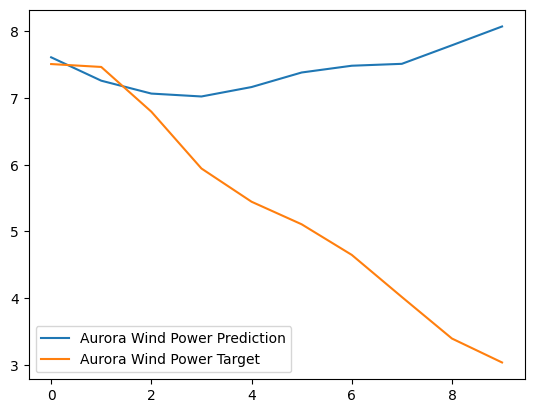

Mean Squared Error: 1.7213191986083984, Mean Absolute Error: 1.2038971185684204, Mean Absolute Percentage Error: 2.258394956588745, Root Mean Squared Error: 1.31199049949646


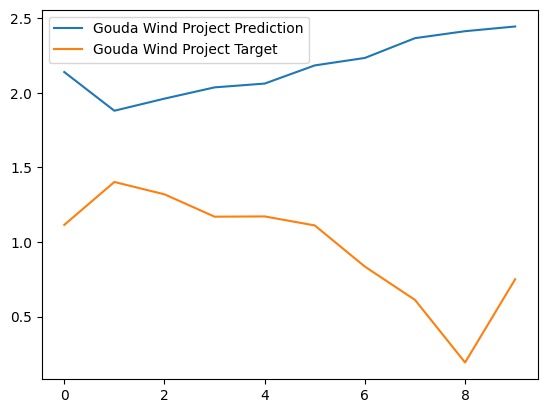

Mean Squared Error: 7.8701887130737305, Mean Absolute Error: 2.392096996307373, Mean Absolute Percentage Error: 1.7420870065689087, Root Mean Squared Error: 2.8053855895996094


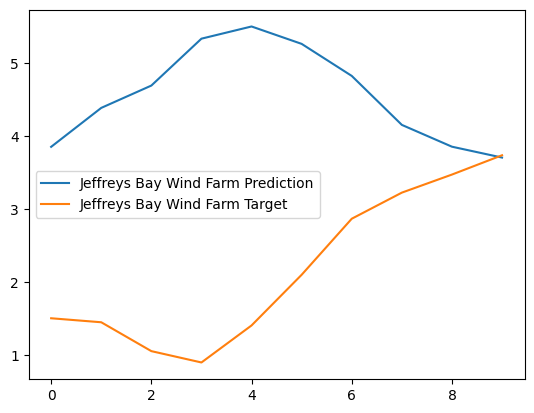

Mean Squared Error: 0.8772726058959961, Mean Absolute Error: 0.8087708353996277, Mean Absolute Percentage Error: 0.2593455910682678, Root Mean Squared Error: 0.9366283416748047


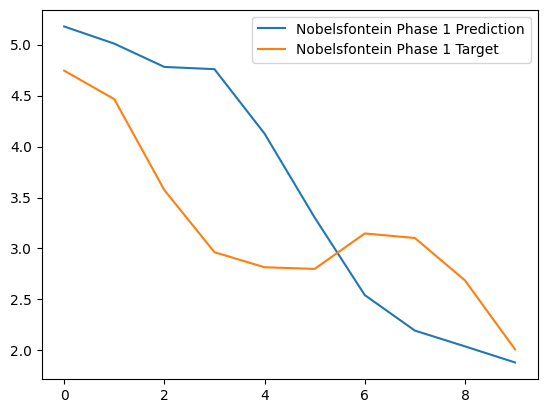

Mean Squared Error: 12.604219436645508, Mean Absolute Error: 3.0141940116882324, Mean Absolute Percentage Error: 1.0311579704284668, Root Mean Squared Error: 3.5502421855926514


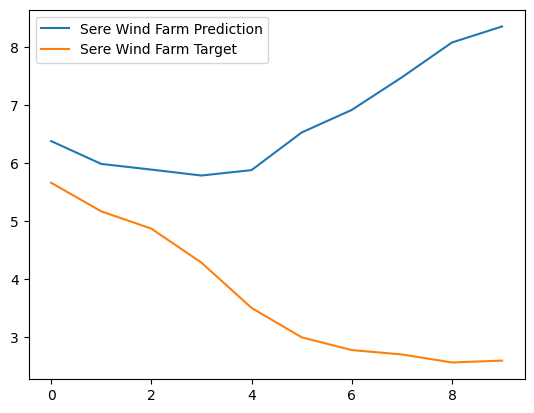

In [42]:
# Compare areas

wind_farms = [
    # {"name": "Amakhala Emoyeni", "location": [-32.6030, 25.9280]},
    {"name": "Aurora Wind Power", "location": [-32.9141, 17.9911]},
    # {"name": "Chaba Wind Farm", "location": [-32.8250, 27.8250]},
    # {"name": "Cookhouse Wind Farm", "location": [-32.7494, 25.6931]},
    # {"name": "Copperton Windfarm", "location": [-29.9569, 24.7083]},
    # {"name": "Dassieklip Wind Energy Facility", "location": [-34.1872, 19.4328]},
    # {"name": "Dorper Wind Farm", "location": [-31.4072, 26.3624]},
    # {"name": "Excelsior Wind Energy Facility", "location": [-34.0226, 20.4417]},
    # {"name": "Garob Wind Farm", "location": [-29.9556, 24.7081]},
    # {"name": "Golden Valley Wind", "location": [-32.7955, 25.7254]},
    {"name": "Gouda Wind Project", "location": [-33.3194, 19.1000]},
    # {"name": "Grassridge Wind Farm", "location": [-33.7975, 25.6251]},
    {"name": "Jeffreys Bay Wind Farm", "location": [-34.0500, 24.9200]},
    # {"name": "Kangnas Wind Farm", "location": [-29.6811, 17.8778]},
    # {"name": "Khobab Wind Farm", "location": [-31.3500, 19.7500]},
    # {"name": "Kouga Wind Farm", "location": [-34.0472, 24.9225]},
    # {"name": "Loeriesfontein 2 Wind Farm", "location": [-30.8865, 19.8085]},
    # {"name": "Longyuan Mulilo De Aar Maanhaarberg Wind Energy Facility", "location": [-30.6815, 24.0125]},
    # {"name": "Longyuan Mulilo Green Energy De Aar 2 North Wind Energy Facility", "location": [-30.6485, 23.9442]},
    # {"name": "Metrowind Van Stadens Wind Farm", "location": [-33.9126, 25.2482]},
    {"name": "Nobelsfontein Phase 1", "location": [-31.3831, 23.1906]},
    # {"name": "Nojoli Wind Farm", "location": [-32.8081, 25.6673]},
    # {"name": "Noupoort Wind Farm", "location": [-31.6381, 24.8819]},
    # {"name": "Nxuba Wind Farm", "location": [-32.7071, 25.7333]},
    # {"name": "Oyster Bay Wind Farm", "location": [-34.0261, 24.9467]},
    # {"name": "Perdekraal East Wind Farm", "location": [-33.3400, 19.2500]},
    # {"name": "Red Cap – Gibson Bay", "location": [-34.0333, 24.9167]},
    # {"name": "Roggeveld Wind Farm", "location": [-32.3928, 20.8311]},
    {"name": "Sere Wind Farm", "location": [-31.7500, 18.0833]},
    # {"name": "The Karusa Wind Farm", "location": [-32.3906, 20.8242]},
    # {"name": "Tsitsikamma Community Wind Farm", "location": [-34.1862, 24.5256]},
    # {"name": "Umoya Energy Wind Farm", "location": [-33.0011, 18.3486]},
    # {"name": "Waainek Wind Farm", "location": [-33.3042, 26.5247]},
    # {"name": "Wesley-Ciskei", "location": [-34.0167, 26.5333]}
]

color = ['b', 'g', 'r', 'c', 'k']

for wind_farm in wind_farms:
    latitude, longitude = wind_farm['location']
    name = wind_farm['name']

    pred = ds_new.sel(latitude=latitude, longitude=longitude, method='nearest')['rollout_pred']
    target = ds_new.sel(latitude=latitude, longitude=longitude, method='nearest')['target']

    plt.plot(pred, label=f'{name} Prediction')
    plt.plot(target, label=f'{name} Target')
    plt.legend()

    mse, mae, mape, rmse = mean_squared_error(target, pred), mean_absolute_error(target, pred), mean_absolute_percentage_error(target, pred), np.sqrt(mean_squared_error(target, pred))
    print(f'Mean Squared Error: {mse}, Mean Absolute Error: {mae}, Mean Absolute Percentage Error: {mape}, Root Mean Squared Error: {rmse}')
    plt.show()